## Linear Regression

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.set_random_seed(0)
np.random.seed(0)

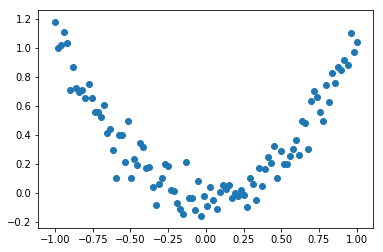

In [9]:
x = np.linspace(-1,1,100).reshape(100,1)
noise = np.random.normal(0, 0.1, size=x.shape)
y = np.power(x,2) + noise
plt.scatter(x, y)
plt.show()

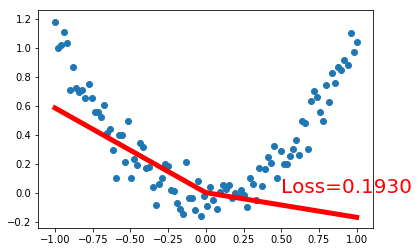

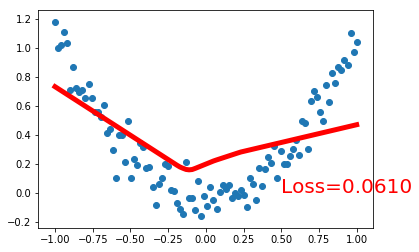

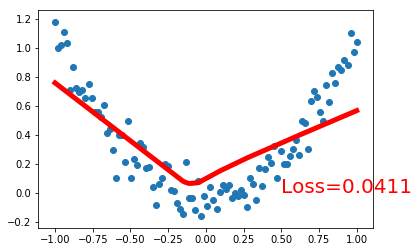

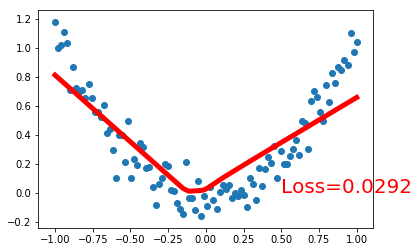

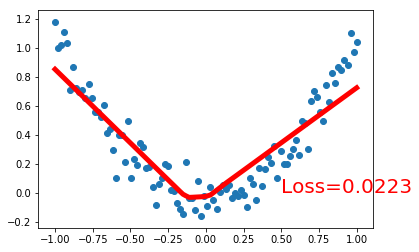

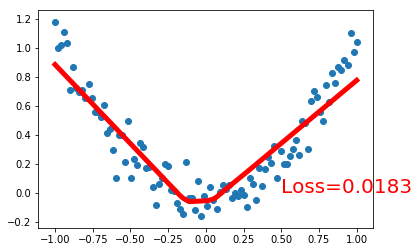

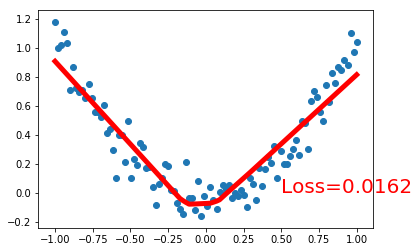

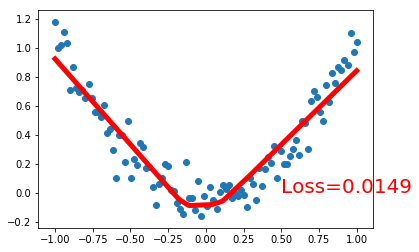

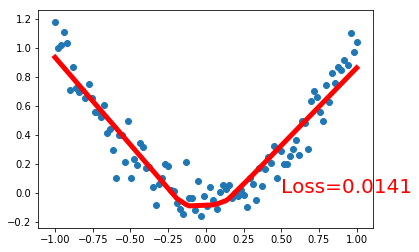

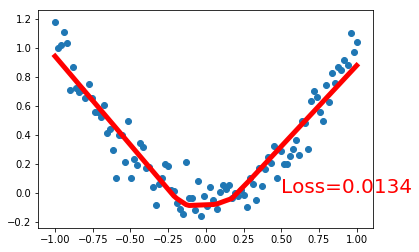

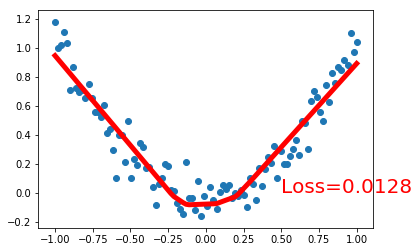

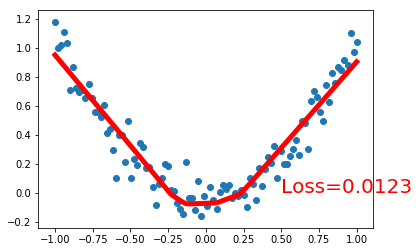

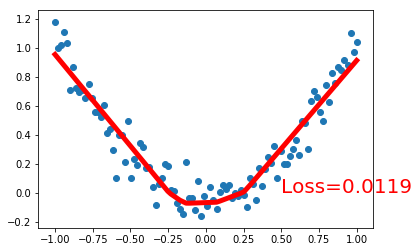

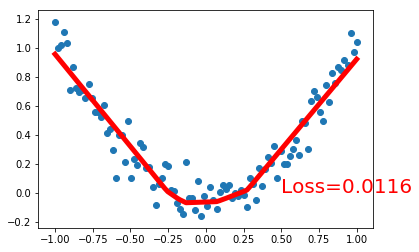

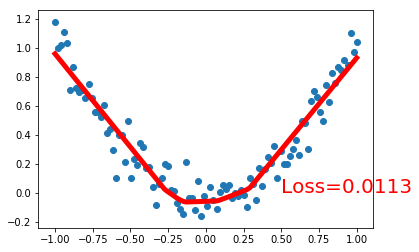

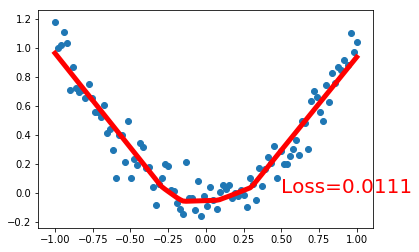

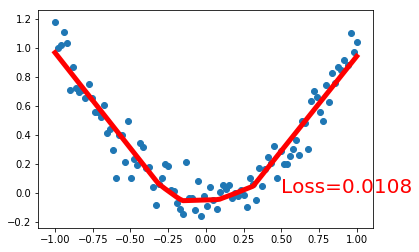

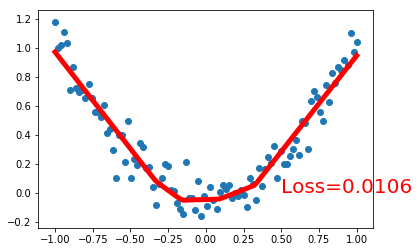

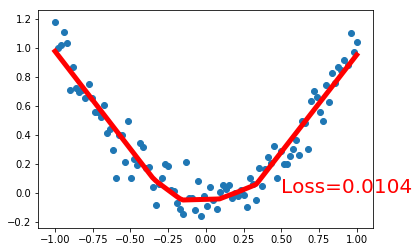

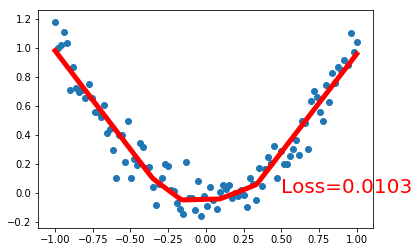

In [11]:
tf_x = tf.placeholder(tf.float32, x.shape)
tf_y = tf.placeholder(tf.float32, y.shape)

l1 = tf.layers.dense(tf_x, 10, tf.nn.relu)
output = tf.layers.dense(l1, 1)

loss = tf.losses.mean_squared_error(tf_y, output)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train_op = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    
    for step in range(100):
        _, l, pred = sess.run([train_op, loss, output], {tf_x: x, tf_y: y})
        if step % 5 == 0:
            plt.cla()
            plt.scatter(x, y)
            plt.plot(x, pred, 'r-', lw=5)
            plt.text(0.5, 0, 'Loss=%.4f' % l, fontdict={'size': 20, 'color': 'red'})
            plt.pause(0.1)
    plt.ioff()
    plt.show()

## Classification

In [40]:
tf.set_random_seed(0)
np.random.seed(0)

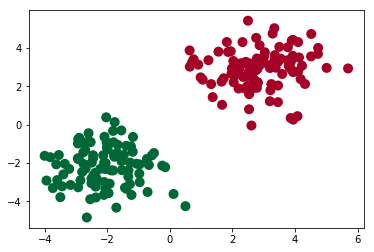

In [44]:
n_data = np.ones([100,2])
x0 = np.random.normal(2*n_data+1)
y0 = np.zeros(100)
x1 = np.random.normal(-2*n_data, 1)
y1 = np.ones(100)
x = np.vstack([x0,x1])
y = np.hstack([y0,y1])
plt.scatter(x[:, 0], x[:, 1], c=y, s=100, lw=0, cmap='RdYlGn')
plt.show()

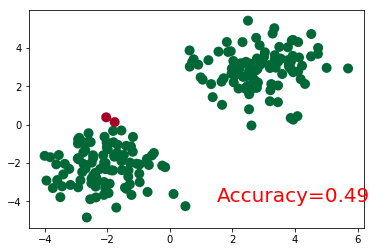

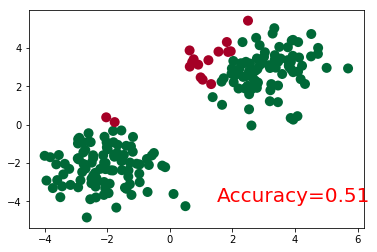

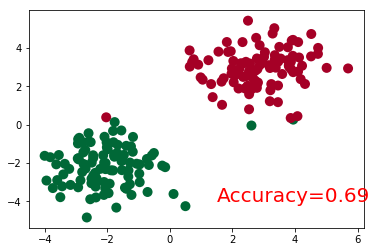

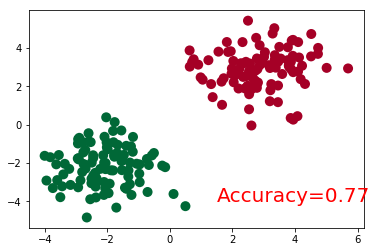

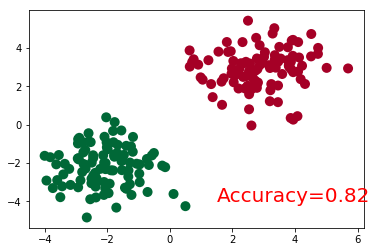

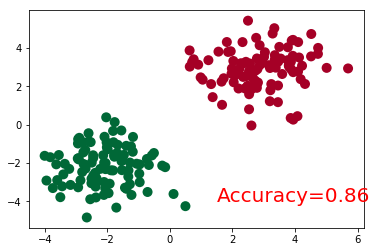

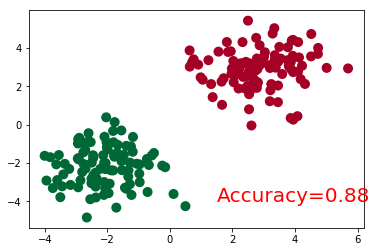

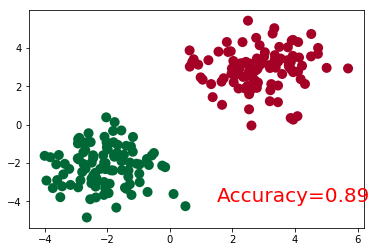

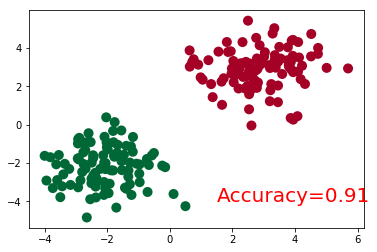

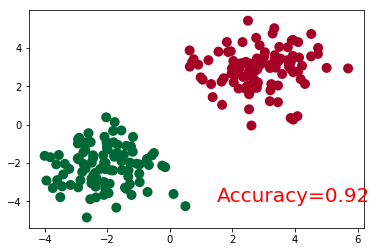

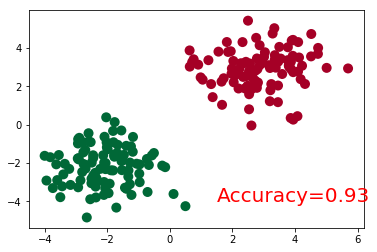

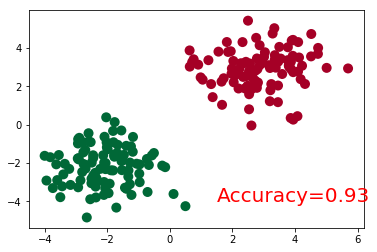

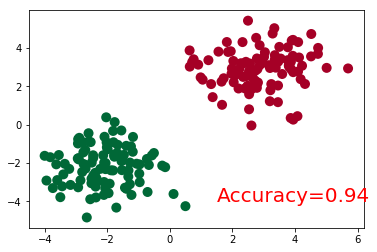

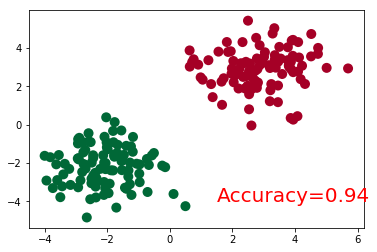

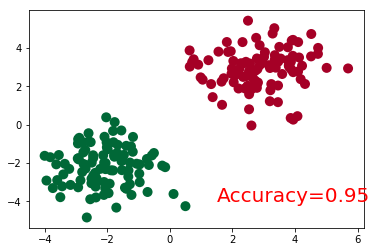

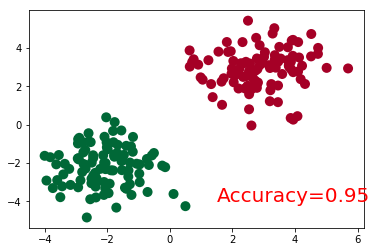

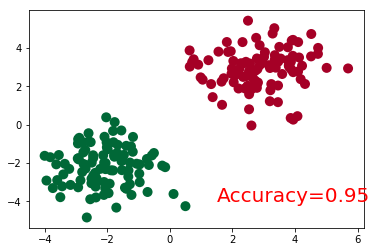

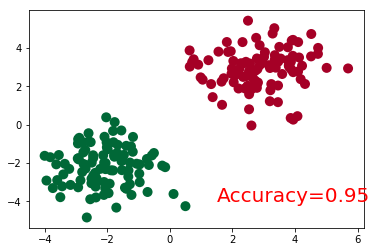

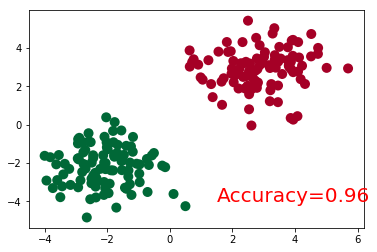

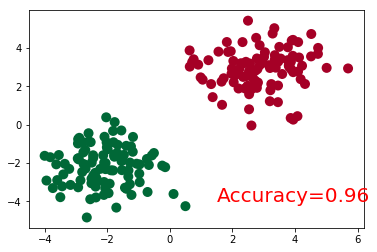

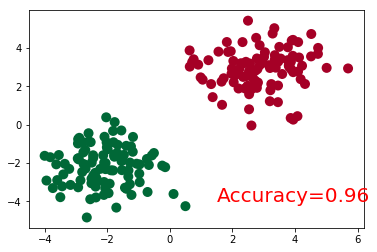

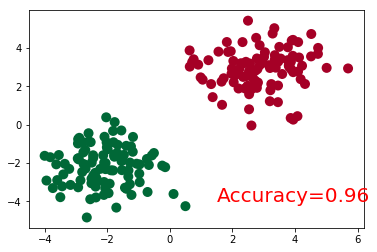

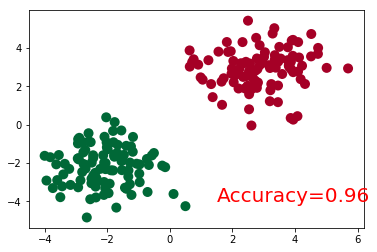

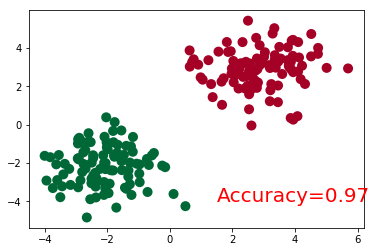

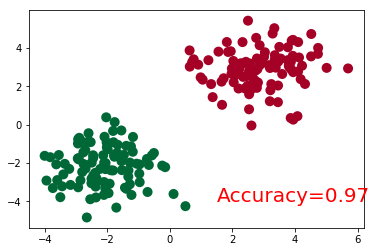

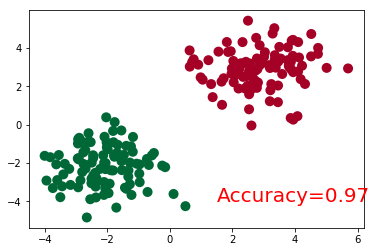

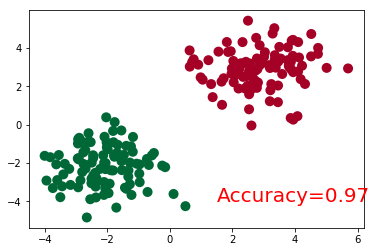

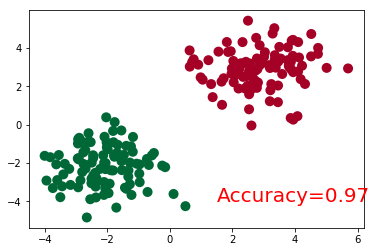

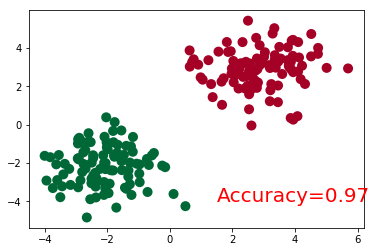

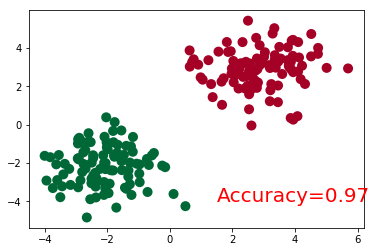

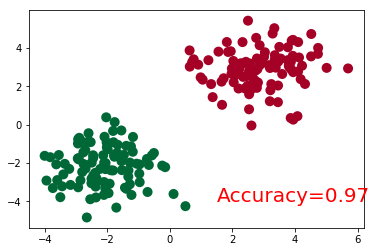

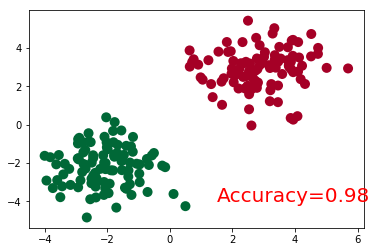

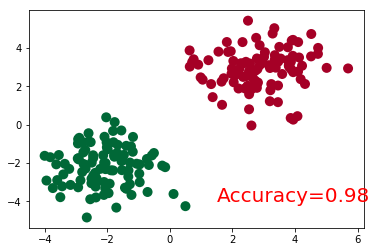

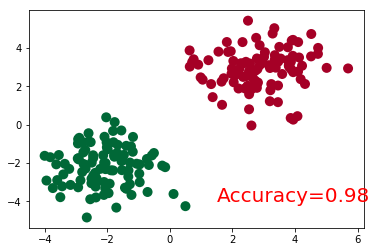

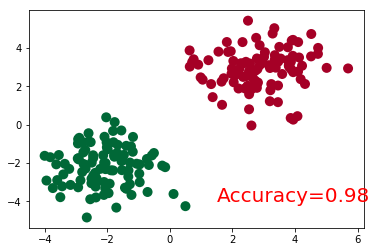

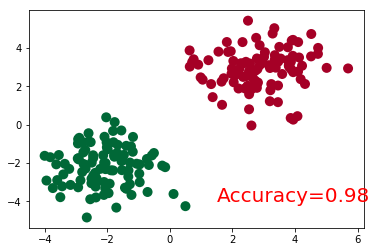

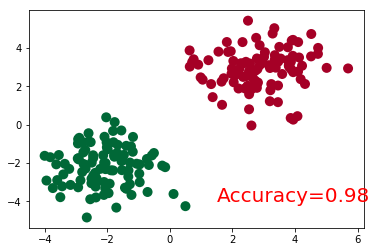

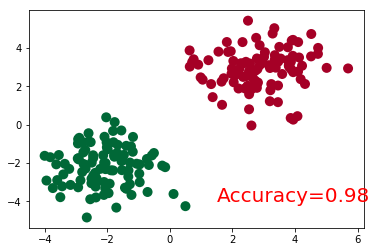

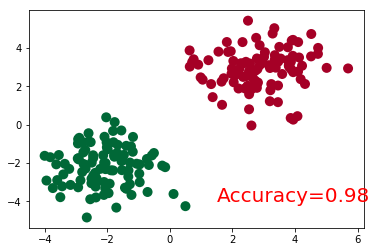

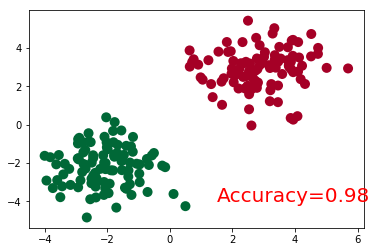

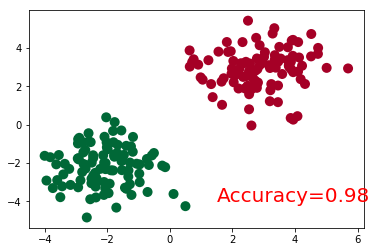

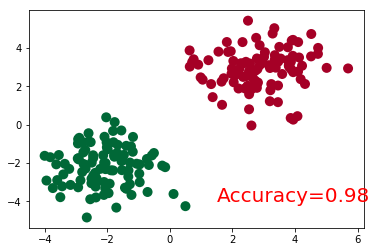

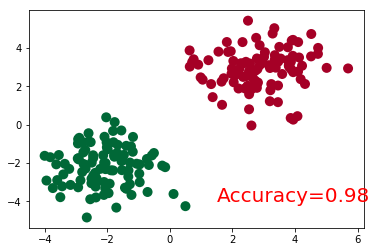

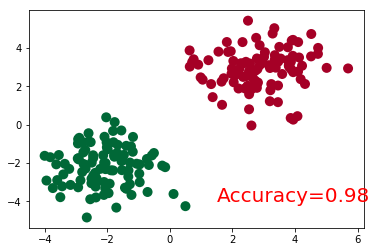

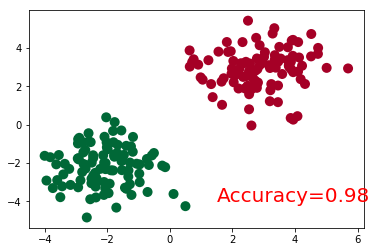

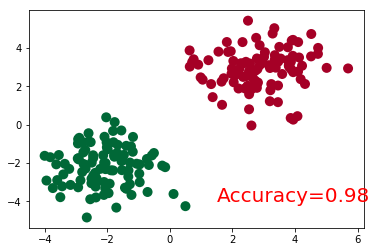

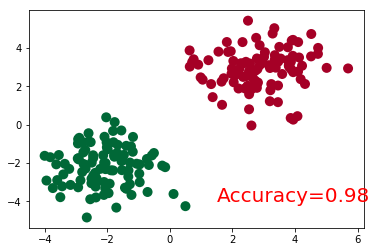

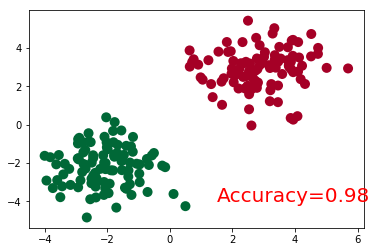

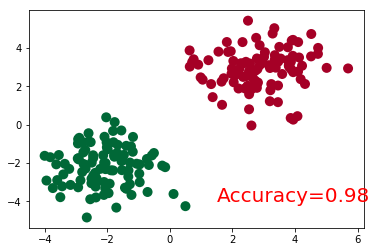

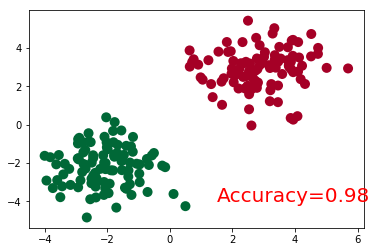

In [46]:
tf_x = tf.placeholder(tf.float32, x.shape)
tf_y = tf.placeholder(tf.int32, y.shape)

l1 = tf.layers.dense(tf_x, 10, tf.nn.relu)
output = tf.layers.dense(l1, 2)

loss = tf.losses.sparse_softmax_cross_entropy(labels=tf_y, logits=output)
accuracy = tf.metrics.accuracy(labels=tf.squeeze(tf_y), predictions=tf.argmax(output, axis=1),)[1]
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
train_op = optimizer.minimize(loss)

with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)

    plt.ion()
    for step in range(100):
        _, acc, pred = sess.run([train_op, accuracy, output], {tf_x: x, tf_y: y})
        if step % 2 == 0:
            plt.cla()
            plt.scatter(x[:, 0], x[:, 1], c=pred.argmax(1), s=100, lw=0, cmap='RdYlGn')
            plt.text(1.5, -4, 'Accuracy=%.2f' % acc, fontdict={'size': 20, 'color': 'red'})
            plt.pause(0.1)

    plt.ioff()
    plt.show()

## Optimizers

In [47]:
tf.set_random_seed(1)
np.random.seed(1)

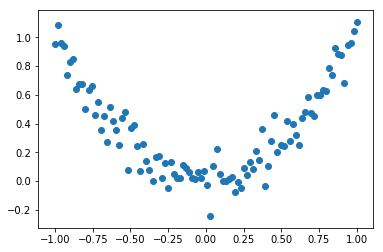

In [49]:
x = np.linspace(-1, 1, 100)[:, np.newaxis]
noise = np.random.normal(0, 0.1, size=x.shape)
y = np.power(x, 2) + noise

plt.scatter(x, y)
plt.show()

In [61]:
LR = 0.01
BATCH_SIZE = 32

class NNet:
    def __init__(self, opt, **kwargs):
        self.x = tf.placeholder(tf.float32, [None, 1])
        self.y = tf.placeholder(tf.float32, [None, 1])
        l = tf.layers.dense(self.x, 20, tf.nn.relu)
        out = tf.layers.dense(l, 1)
        self.loss = tf.losses.mean_squared_error(self.y, out)
        self.train = opt(LR, **kwargs).minimize(self.loss)

In [62]:
net_SGD         = NNet(tf.train.GradientDescentOptimizer)
net_Momentum    = NNet(tf.train.MomentumOptimizer, momentum=0.9)
net_RMSprop     = NNet(tf.train.RMSPropOptimizer)
net_Adam        = NNet(tf.train.AdamOptimizer)
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

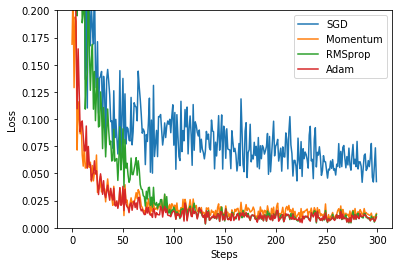

In [65]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses_his = [[], [], [], []]
    
    for step in range(300):
        index = np.random.randint(0, x.shape[0], BATCH_SIZE)
        b_x = x[index]
        b_y = y[index]
        
        for net, l_his in zip(nets, losses_his):
            _, l = sess.run([net.train, net.loss], {net.x: b_x, net.y: b_y})
            l_his.append(l)

    labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
    for i, l_his in enumerate(losses_his):
        plt.plot(l_his, label=labels[i])
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, 0.2))
    plt.show()

## Dataset

In [67]:
npx = np.random.uniform(-1, 1, (1000, 1))
npy = np.power(npx, 2) + np.random.normal(0, 0.1, size=npx.shape)
npx_train, npx_test = np.split(npx, [800])
npy_train, npy_test = np.split(npy, [800])

tfx = tf.placeholder(npx_train.dtype, npx_train.shape)
tfy = tf.placeholder(npy_train.dtype, npy_train.shape)

dataset = tf.data.Dataset.from_tensor_slices((tfx, tfy))
dataset = dataset.shuffle(buffer_size=1000) 
dataset = dataset.batch(32)                 
dataset = dataset.repeat(3)                 
iterator = dataset.make_initializable_iterator()  

bx, by = iterator.get_next()
l1 = tf.layers.dense(bx, 10, tf.nn.relu)
out = tf.layers.dense(l1, npy.shape[1])
loss = tf.losses.mean_squared_error(by, out)
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

with tf.Session() as sess:
    sess.run([iterator.initializer, tf.global_variables_initializer()], feed_dict={tfx: npx_train, tfy: npy_train})
    for step in range(201):
        try:
            _, trainl = sess.run([train, loss])                       
            if step % 10 == 0:
                testl = sess.run(loss, {bx: npx_test, by: npy_test})  
                print('step: %i/200' % step, '|train loss:', trainl, '|test loss:', testl)
        except tf.errors.OutOfRangeError:     
            print('Finish the last epoch.')
            break

Instructions for updating:
Use the retry module or similar alternatives.


ImportError: cannot import name 'Dataset'